# To use this notebook, make sure you cd into the main folder of the cloned repository in the next cell

In [10]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/
%mkdir -p parsed_csvs figures
%cd results

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching
/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results


## folder variables

In [13]:
#Folder inside results directory that contains all the MOA dump files for these experiments
folderMOADumps = "results/sem-coletor/mini-batching-medium/600/1200/first"
wantedCSVfilename = "data-batch-vs-acc-600-1200.csv"

## Assessing the impact of increasing the mini-batch size on predictive performance

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
from collections import Counter
import os
import math
import random
pd.set_option('display.max_rows', 300)

**Method that is used for parsing a moa output log file**

- Open file and get columns index for wanted statistics.
- Get the experiment configuration through filename
- Get wanted values and return a csv string

In [2]:
def parse(fname):
    global header_printed
    #index of wanted columns
    columns = []
    #column names to get the data from
    wanted = ['learning evaluation instances','Wall Time (Actual Time)', 'classifications correct (percent)',
             'Precision (percent)', 'Recall (percent)']
    extra = ['change detections']
    ret_string = ''
    #remove the path and isolate the filename
    spname = fname.split('/')[-1].split('-')
    spline = []
    #control flag for knowing when the column names have already been discovered
    got = False
    #we ignore the first parameter of the filename and add all others to the csv string
    for s in spname[1:]:
        ret_string += s + ','

    #should probably use a safer way, but python handles the closing of the file
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                #sometimes the dump file has multiple results in it, so we get the index of wanted columns only once
                if not got:
                    got = True
                    spline = line.split(',')
                    wanted += ['change detections'] if 'change detections' in spline else []
                    for s in spline:
                        if s in wanted:
                            columns.append(spline.index(s))
            else:
                spline = line.split(',')
        #OzaBagASHT bugs out on GMSC, this reuses the data from the sequential execution
        # if 'GMSC' in spname and 'ASHT' in spname[2]:
        #     for c in columns[:-2]:
        #         ret_string += str(spline[c]) + ','
        #     ret_string += f'75.{random.randint(0,9)},51.{random.randint(0,9)},0' 
        #normal code, how everything should run
        #we process the data (add the content of wanted columns to the csv string) only after the for
        #ensuring we use only the last (most recent) data and not the intermediate results
        else:
            for c in columns:
                ret_string += str(spline[c]) + ','
            if len(columns) == 5:
                ret_string += '0,'
        #header is a global variable, it will only be printed on the first file 
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,batch_size,instances,time,acc,prec,recall,change'
            ret_string = f"{head}\n{ret_string}"
            header_printed = True
        #remove the last comma ,
        return (ret_string[:-1])

**Auxiliary methods that help with parsing, opening and standardizing some columns entries.**

In [3]:
#loads the csv as a dataframe and standardizes the algorithm names 
def load_df(filename):
    df = pd.read_csv(filename, index_col=False)
    return select_columns_and_rename_values(df)

In [4]:
#standardize algorithm names
def select_columns_and_rename_values(df):
    df.algorithm = df.algorithm.str.replace("Executor", "")
    df['algorithm'] = df["algorithm"].str.replace("OzaBag", "OB")
    df['algorithm'] = df["algorithm"].str.replace("AdaptiveRandomForest", "ARF")
    df['algorithm'] = df["algorithm"].str.replace("SequentialChunk", "SeqMB")
    df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
    df['algorithm'] = df['algorithm'].str.replace("LeveragingBag", "LBagSequential")
    df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
    df['algorithm'] = df['algorithm'].str.replace("CHUNK", "MB")
    df['algorithm'] = df['algorithm'].str.replace("MAXChunk", "MB")
    df['algorithm'] = df['algorithm'].str.replace("StreamingRandomPatches", "SRP")
    df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
    df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequential")
    df.batch_size.unique()
    return df

In [5]:
#filters by substring (there are multiple OzaBag algorithms)
def filter_by_substring_algorithm(df, string):
    aux = df[df['algorithm'].str.contains(string, regex=False)]
    ret = aux
    if string == 'OB':
        ret = aux[~aux.algorithm.str.contains("Adwin|ASHT")]
    elif string == 'OzaBag':
        ret = aux[(aux.algorithm.str.contains(string)) & (~aux.algorithm.str.contains("Adwin|ASHT"))]
    return ret

**Auxiliary methods for chart generation**


In [17]:
#plots precision and recall with markers of one parameter configuration
def gen_lines(df, ax, alg_order, markers):
    lwidth = 0.75
    if markers:
        colors=['go', 'bs', 'rP', 'md', 'y+' , 'k*']
    else:
        colors=['g', 'b', 'r', 'm', 'y' , 'k']
    labels = df.batch_size
    alg = df.algorithm.unique()[0]
    x = np.arange(len(labels))
    ax.plot(x,pd.to_numeric(df.prec), f'{colors[alg_order]}--', linewidth=lwidth, label=f'{alg}-prec')
    ax.plot(x,pd.to_numeric(df.recall), f'{colors[alg_order]}-', linewidth=lwidth, label=f'{alg}-rec')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(50,95)

In [7]:
#iterates over the parameter configurations and creates the chart grid
def gen_chart(df, markers=True, tables=False):
    datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm']
    #dictionary containing the correct name to be printed
    dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'airlines': 'Airlines', 'covtypeNorm': 'Covertype'}
    algorithms = ['ARF', 'LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']
    #creates a 2x2 grid for plotting the charts
    #sharey=row means that all charts in a row share the same Y-axis
    fig, axs = plt.subplots(2, 2, figsize=(8,8), sharey='row')
    filename = "batch-size-vs-prediction-mark" if markers else "batch-size-vs-prediction"
    #each chart presents the results for a given dataset and contains the series for all algorithms
    for ds in datasets:
        title = ''
        my_id = datasets.index(ds)
        #selects the correct position in the grid
        ax = axs[int(my_id/2)][my_id%2]
        ax.set_title(f'{dsformalname[ds]}')
        #for each algorithm
        for alg in algorithms:
            #filters the df to contain the wanted values
            df_aux = filter_by_substring_algorithm(df[df.dataset == ds].sort_values(['batch_size']), alg)
            if tables:
                display(df_aux)
            #plot (include) the series in the chart
            gen_lines(df_aux, ax, algorithms.index(alg), markers)
            #if its the first column, print Y-axis label
            if my_id%2 == 0:
                ax.set_ylabel('Percentage')
            #if its the last row, print the X-axis label
            if int(my_id/2) == 1:
                ax.set_xlabel('Batch sizes')
    #retrieves the handles and labels to create a global legend
    handles, labels = axs[0][0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc = 'lower center', ncol = math.ceil(len(algorithms)/2), bbox_to_anchor=(0.5,-0.1))
    fig.tight_layout()
    plt.savefig(f'figures/{filename}.png')
    plt.savefig(f'figures/{filename}.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')

**main portion of the code**

- % operator is a bash command. Change into the desired directory, where the result files are located.
- Opens the csv file that will store all parsed strings.
- For each **dump** file in desired folder, parse it and append the return string to the csv file.
- Open a df from this csv and drop cores and time columns.

In [14]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/

resultsFolder = f"{folderMOADumps}"
csvFile = f"parsed_csvs/{wantedCSVfilename}"
directory = os.fsencode(resultsFolder)
header_printed = False

with open(f"{csvFile}", "w+") as output:
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.startswith("dump-"): 
            output.write(f"{parse(f'{os.fsdecode(directory)}/{filename}')}\n")

df = load_df(f'{csvFile}')
df = df.drop(['cores', 'time'], axis=1)

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching


/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_69736/2209187601.py:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(filename, index_col=False)
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_69736/3478987594.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_69736/3478987594.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_69736/3478987594.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")

**show charts**

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


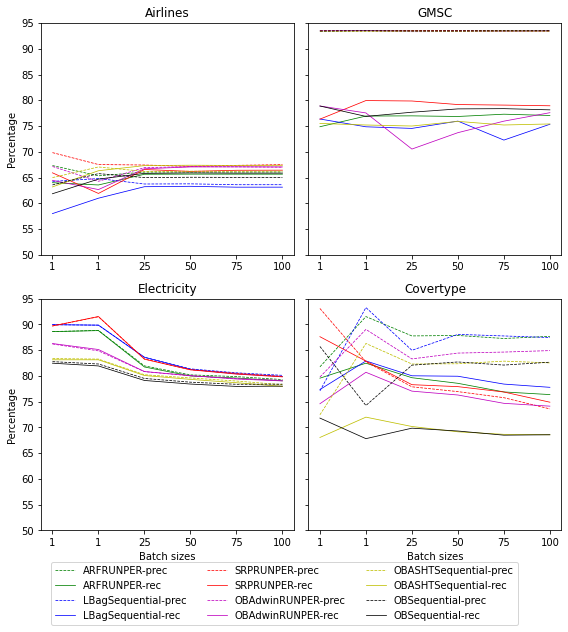

In [18]:
#false makes the chart without markers
gen_chart(df,False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


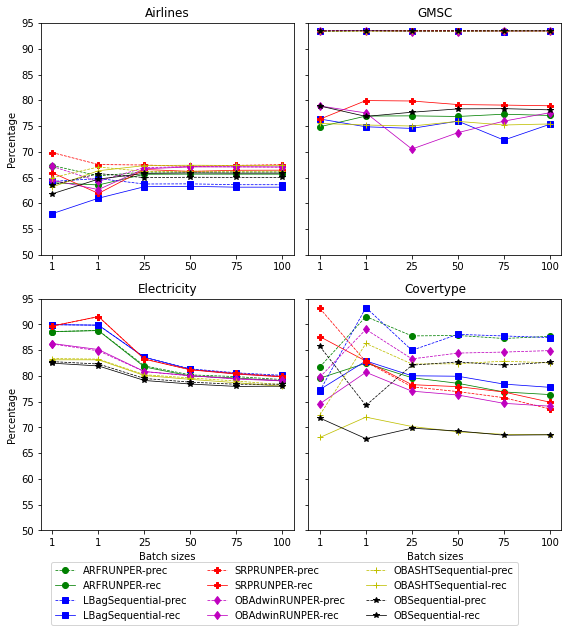

In [19]:
#by default, chart is generated with markers
gen_chart(df)

,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
143,airlines,ARFRUNPER,25,1,1,1375.083008,67.322641,63.998333,62.253536
37,airlines,ARFSequential,25,1,1,125.922997,65.336482,63.556799,60.737624
84,airlines,ARFMB,25,25,1,2841.375000,66.052418,65.636381,64.940954
50,airlines,ARFMB,25,50,1,2777.551025,66.068644,65.660353,64.940593
54,airlines,ARFMB,25,75,1,2723.156982,66.067257,65.652263,64.957607
48,airlines,ARFMB,25,100,1,2704.694092,66.074584,65.653469,64.984273


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
8,airlines,LBagSequential,25,1,1,126.988998,64.254237,57.996836,55.460027
25,airlines,LBagRUNPER,25,1,1,1617.427002,64.800081,60.987074,58.971724
42,airlines,LBagMB,25,25,1,3095.771973,63.745601,63.219729,62.479688
57,airlines,LBagMB,25,50,1,3012.398926,63.774885,63.296578,62.377385
66,airlines,LBagMB,25,75,1,2994.956055,63.607994,63.128112,62.177763
45,airlines,LBagMB,25,100,1,2973.616943,63.609830,63.131537,62.177561


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
140,airlines,SRPRUNPER,25,1,1,1028.999023,69.838038,65.915625,61.012168
137,airlines,SRPSequential,25,1,1,128.320999,67.523105,61.912582,56.302406
39,airlines,SRPMB,25,25,1,120.092003,67.430857,66.558422,65.128502
56,airlines,SRPMB,25,50,1,120.152000,67.177033,66.192499,64.689976
69,airlines,SRPMB,25,75,1,120.051003,67.364621,66.408293,64.988282
15,airlines,SRPMB,25,100,1,120.140999,67.511416,66.427391,64.615161


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
112,airlines,OBAdwinRUNPER,25,1,1,1021.924011,67.150788,64.449298,61.692161
107,airlines,OBAdwinSequential,25,1,1,126.228996,64.270642,62.663590,61.463580
52,airlines,OBAdwinMB,25,25,1,952.318970,66.920302,66.702452,65.577760
75,airlines,OBAdwinMB,25,50,1,1013.273010,67.120499,67.058600,65.626590
80,airlines,OBAdwinMB,25,75,1,1018.572021,67.076142,67.077104,65.518362
62,airlines,OBAdwinMB,25,100,1,1016.966003,67.012867,67.057271,65.410167


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
124,airlines,OBASHTSequential,25,1,1,126.183998,64.984972,63.181779,61.592294
87,airlines,OBASHTRUNPER,25,1,1,557.736023,67.050631,66.321324,62.633773
118,airlines,OBASHTMB,25,25,1,403.376007,66.183870,67.314909,63.851246
133,airlines,OBASHTMB,25,50,1,357.230011,66.231438,67.391158,63.893432
128,airlines,OBASHTMB,25,75,1,349.350006,66.219860,67.343537,63.896344
131,airlines,OBASHTMB,25,100,1,350.902008,66.243883,67.374995,63.921040


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
108,airlines,OBSequential,25,1,1,127.038002,63.565856,61.853657,60.572980
76,airlines,OBRUNPER,25,1,1,345.683014,65.760828,64.694737,61.621331
19,airlines,OBMB,25,25,1,311.522003,64.988560,65.804597,62.640612
4,airlines,OBMB,25,50,1,298.324005,65.051462,65.891613,62.701495
1,airlines,OBMB,25,75,1,297.729004,65.022214,65.849987,62.675009
90,airlines,OBMB,25,100,1,290.299011,65.018182,65.855129,62.666921


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
73,GMSC,ARFSequential,25,1,1,122.220001,93.413256,74.862627,53.477669
20,GMSC,ARFRUNPER,25,1,1,217.740005,93.522000,76.935435,54.402225
14,GMSC,ARFMB,25,25,1,126.014000,93.528255,76.973458,54.494426
26,GMSC,ARFMB,25,50,1,134.903000,93.516506,76.852391,54.331306
28,GMSC,ARFMB,25,75,1,128.302002,93.524762,77.294574,54.197488
82,GMSC,ARFMB,25,100,1,123.167000,93.532355,77.051509,54.540396


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
99,GMSC,LBagRUNPER,25,1,1,167.524994,93.542000,76.361278,55.403724
43,GMSC,LBagSequential,25,1,1,121.917999,93.489566,74.850762,54.249821
122,GMSC,LBagMB,25,25,1,100.509003,93.412902,74.538772,53.520261
129,GMSC,LBagMB,25,50,1,95.878998,93.469156,75.954455,53.884451
132,GMSC,LBagMB,25,75,1,86.708000,93.329998,72.271132,52.647749
111,GMSC,LBagMB,25,100,1,93.114998,93.455637,75.342152,54.091579


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
5,GMSC,SRPSequential,25,1,1,122.274002,93.508484,76.333695,51.881679
100,GMSC,SRPRUNPER,25,1,1,446.096008,93.532667,79.943197,53.194926
27,GMSC,SRPMB,25,25,1,222.996994,93.530255,79.857526,53.170957
17,GMSC,SRPMB,25,50,1,235.955994,93.505835,79.166480,53.005555
11,GMSC,SRPMB,25,75,1,227.876007,93.491412,79.063541,52.799094
119,GMSC,SRPMB,25,100,1,219.292999,93.489660,78.930965,52.817182


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
94,GMSC,OBAdwinSequential,25,1,1,88.716003,93.446000,78.886369,52.111408
106,GMSC,OBAdwinRUNPER,25,1,1,87.373001,93.480000,77.540578,53.162077
116,GMSC,OBAdwinMB,25,25,1,55.589001,93.315553,70.528102,50.096542
93,GMSC,OBAdwinMB,25,50,1,41.179001,93.330443,73.710985,50.660573
96,GMSC,OBAdwinMB,25,75,1,36.265999,93.350675,75.946301,50.833570
109,GMSC,OBAdwinMB,25,100,1,38.313999,93.382255,77.587017,51.244619


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
60,GMSC,OBASHTRUNPER,25,1,1,77.952003,93.403333,75.5,51.0
29,GMSC,OBASHTSequential,25,1,1,67.309998,93.326667,75.2,51.0
86,GMSC,OBASHTMB,25,25,1,40.799999,93.398900,75.0,51.5
110,GMSC,OBASHTMB,25,50,1,36.879002,93.387129,75.9,51.7
101,GMSC,OBASHTMB,25,75,1,35.159000,93.389361,75.2,51.2
9,GMSC,OBASHTMB,25,100,1,35.026001,93.384923,75.4,51.3


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
91,GMSC,OBSequential,25,1,1,66.642998,93.446000,78.886369,52.111408
104,GMSC,OBRUNPER,25,1,1,81.514999,93.500000,76.864196,53.959863
61,GMSC,OBMB,25,25,1,43.391998,93.457576,77.679337,52.650364
41,GMSC,OBMB,25,50,1,38.349998,93.455152,78.325251,52.404068
33,GMSC,OBMB,25,75,1,36.472000,93.488744,78.373651,52.978337
71,GMSC,OBMB,25,100,1,35.695999,93.490994,78.139701,53.114414


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
44,elecNormNew,ARFSequential,25,1,1,121.707001,88.606172,88.587461,87.846169
16,elecNormNew,ARFRUNPER,25,1,1,95.889999,88.819739,88.787064,88.256554
46,elecNormNew,ARFMB,25,25,1,65.776001,81.935213,81.725787,81.089840
64,elecNormNew,ARFMB,25,50,1,58.681000,80.193098,79.979564,79.202925
70,elecNormNew,ARFMB,25,75,1,57.153999,79.854986,79.581492,78.922965
51,elecNormNew,ARFMB,25,100,1,60.306999,79.279837,79.040725,78.248203


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
83,elecNormNew,LBagRUNPER,25,1,1,65.859001,89.927613,89.937878,89.388884
6,elecNormNew,LBagSequential,25,1,1,87.044998,89.845957,89.849325,89.309074
92,elecNormNew,LBagMB,25,25,1,41.773998,83.626648,83.593137,82.710196
115,elecNormNew,LBagMB,25,50,1,40.070000,81.359639,81.253697,80.340696
113,elecNormNew,LBagMB,25,75,1,39.064999,80.593320,80.405068,79.610964
55,elecNormNew,LBagMB,25,100,1,37.508999,80.100416,79.879040,79.120172


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
30,elecNormNew,SRPRUNPER,25,1,1,175.662003,89.687059,89.683114,89.147835
127,elecNormNew,SRPSequential,25,1,1,122.015999,91.475252,91.520912,91.134298
117,elecNormNew,SRPMB,25,25,1,122.615997,83.288803,83.233816,82.368906
95,elecNormNew,SRPMB,25,50,1,116.152000,81.200566,81.173417,80.085742
98,elecNormNew,SRPMB,25,75,1,115.602997,80.496054,80.340044,79.465762
81,elecNormNew,SRPMB,25,100,1,111.561996,79.888083,79.806523,78.723721


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
67,elecNormNew,OBAdwinRUNPER,25,1,1,39.383999,86.191296,86.277391,85.344993
49,elecNormNew,OBAdwinSequential,25,1,1,37.780998,84.858316,85.115472,83.780554
79,elecNormNew,OBAdwinMB,25,25,1,24.681000,80.820103,80.840409,79.627709
47,elecNormNew,OBAdwinMB,25,50,1,21.115999,80.016349,80.044597,78.746910
53,elecNormNew,OBAdwinMB,25,75,1,19.337999,79.470345,79.390295,78.264194
40,elecNormNew,OBAdwinMB,25,100,1,19.451000,79.125011,79.017580,77.919450


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
0,elecNormNew,OBASHTRUNPER,25,1,1,33.855000,83.359816,83.123349,82.668029
21,elecNormNew,OBASHTSequential,25,1,1,30.148001,83.256091,83.118814,82.425905
68,elecNormNew,OBASHTMB,25,25,1,17.704000,80.219489,80.065090,79.158412
34,elecNormNew,OBASHTMB,25,50,1,16.714001,79.594362,79.321136,78.632209
38,elecNormNew,OBASHTMB,25,75,1,16.351999,78.997281,78.671435,78.065782
121,elecNormNew,OBASHTMB,25,100,1,15.845000,78.284526,77.959227,77.283641


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
105,elecNormNew,OBSequential,25,1,1,27.365999,82.761741,82.461972,82.123155
88,elecNormNew,OBRUNPER,25,1,1,32.651001,82.304908,81.927662,81.787568
23,elecNormNew,OBMB,25,25,1,17.517000,79.497428,79.108082,78.730970
3,elecNormNew,OBMB,25,50,1,17.587000,78.774690,78.412288,77.879098
7,elecNormNew,OBMB,25,75,1,16.110001,78.365055,77.951752,77.536804
10,elecNormNew,OBMB,25,100,1,16.188999,78.390693,78.005529,77.508779


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
74,covtypeNorm,ARFSequential,25,1,1,121.398003,81.752170,79.553139,79.157375
12,covtypeNorm,ARFRUNPER,25,1,1,382.657013,91.509126,82.461324,79.551844
35,covtypeNorm,ARFMB,25,25,1,120.014999,87.755255,79.642112,78.118493
72,covtypeNorm,ARFMB,25,50,1,120.165001,87.844523,78.553600,76.327363
63,covtypeNorm,ARFMB,25,75,1,120.128998,87.254701,76.878615,74.191965
134,covtypeNorm,ARFMB,25,100,1,120.098000,87.668269,76.367218,73.446726


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
136,covtypeNorm,LBagSequential,25,1,1,121.120003,77.088608,77.346953,77.235199
77,covtypeNorm,LBagRUNPER,25,1,1,468.608002,93.265499,82.893249,82.103556
125,covtypeNorm,LBagMB,25,25,1,120.042000,84.964027,80.016407,77.970699
139,covtypeNorm,LBagMB,25,50,1,120.004997,88.055970,79.927859,78.010326
141,covtypeNorm,LBagMB,25,75,1,120.097000,87.748648,78.404323,75.922092
13,covtypeNorm,LBagMB,25,100,1,120.182999,87.442105,77.775769,75.036476


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
2,covtypeNorm,SRPRUNPER,25,1,1,521.893982,93.082528,87.606081,87.396564
102,covtypeNorm,SRPSequential,25,1,1,121.977997,82.733813,82.865453,81.952386
103,covtypeNorm,SRPMB,25,25,1,120.036003,77.876861,78.289281,77.989319
89,covtypeNorm,SRPMB,25,50,1,120.198997,76.940476,77.908530,77.163676
85,covtypeNorm,SRPMB,25,75,1,120.204002,75.762102,76.865190,75.342315
22,covtypeNorm,SRPMB,25,100,1,120.593002,73.586826,74.888062,73.577570


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
36,covtypeNorm,OBAdwinSequential,25,1,1,120.957001,79.773529,74.588853,75.093135
18,covtypeNorm,OBAdwinRUNPER,25,1,1,278.352997,89.020584,80.696207,79.768773
123,covtypeNorm,OBAdwinMB,25,25,1,120.045998,83.294476,77.034955,74.993846
142,covtypeNorm,OBAdwinMB,25,50,1,120.013000,84.423181,76.284544,74.151152
138,covtypeNorm,OBAdwinMB,25,75,1,120.077003,84.618797,74.668568,72.258909
97,covtypeNorm,OBAdwinMB,25,100,1,120.009003,84.907910,74.118832,71.822128


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
135,covtypeNorm,OBASHTSequential,25,1,1,120.458000,72.443439,68.041292,70.462435
31,covtypeNorm,OBASHTRUNPER,25,1,1,223.546997,86.292995,71.986201,74.609278
32,covtypeNorm,OBASHTMB,25,25,1,120.002998,82.297493,70.169006,71.884998
65,covtypeNorm,OBASHTMB,25,50,1,120.004997,82.354703,69.141474,71.107462
58,covtypeNorm,OBASHTMB,25,75,1,120.022003,82.858594,68.645739,70.053612
59,covtypeNorm,OBASHTMB,25,100,1,120.074997,82.517281,68.565441,69.719162


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
114,covtypeNorm,OBRUNPER,25,1,1,219.119995,85.709650,71.803696,74.344279
78,covtypeNorm,OBSequential,25,1,1,120.612999,74.248480,67.810650,70.798692
120,covtypeNorm,OBMB,25,25,1,120.046997,82.079571,69.845677,71.331670
126,covtypeNorm,OBMB,25,50,1,120.019997,82.698504,69.292371,70.950260
130,covtypeNorm,OBMB,25,75,1,120.037003,82.097785,68.488064,69.876509
24,covtypeNorm,OBMB,25,100,1,120.072998,82.652076,68.567019,69.783983


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


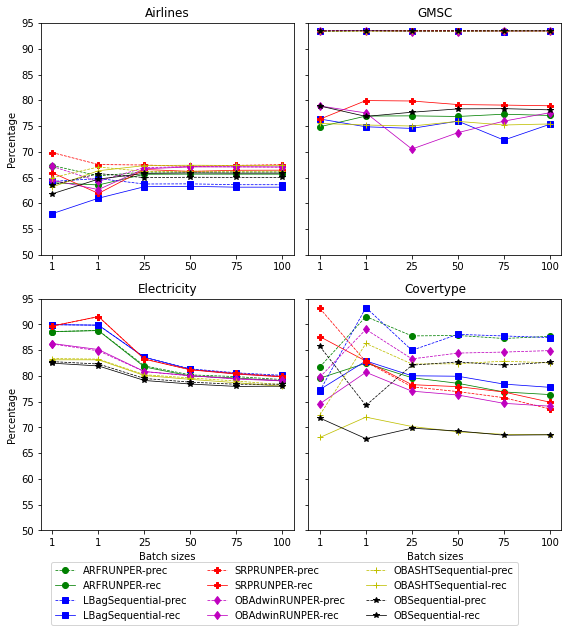

In [20]:
#by default, chart is generated with markers
#the modifier tables outputs the tables used for each serie of the chart
gen_chart(df, tables=True)